In [1]:
import pathlib
import imageio
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [3]:
## Path
path = '/Users/SinVinVin/Desktop/data-science-bowl-2018/stage1_train/'
##create array that contain all train_files_id as string
train_ids = next(os.walk(path))[1] # 1 is to ignore the string "path"
ids = train_ids
##Image_size is 128X128 as input of the Unet model 
image_size = 128

def readin(id_name):
    ## due to the structure of the directory, image path and mask path are separated
    ## "id_name" - string of the files names and joining to be the new path for image and mask
    image_path = os.path.join(path, id_name, "images", id_name) + ".png"
    mask_path = os.path.join(path, id_name, "masks/")
    ## within the masks folder, there are multiple masks 
    ## so mask_s will be a list with all names in given path
    mask_s = os.listdir(mask_path)
    
    ## Reading Image
    ## Using openCV to read an image, so there will be a loop below
    image = cv2.imread(image_path, 1)
    ## resize the image to 128X128
    image = cv2.resize(image, (image_size, image_size))
    ## creating the image layer to enhance the contrast
    image_upper = np.amax(image)
    image_lower = np.amin(image)
    image = ((image-image_lower)/(image_upper-image_lower))*255
    ## after layering the images are too exposed to light
    ## Therefore we normalize the values by keeping them between 0&1
    image = image/255.0
#######Mask
    #Create empty array for mask
    mask = np.zeros((image_size, image_size, 1))
    ## Reading Masks
    for file_name in mask_s:
        mask_path_file = mask_path + file_name
        mask_image = cv2.imread(mask_path_file, -1)
        mask_image = cv2.resize(mask_image, (image_size, image_size)) #128x128
        mask_image = np.expand_dims(mask_image, axis=-1)
        ## Using np.maximum to stack all the array with white spots on mask image
        ## onto a single image
        mask = np.maximum(mask, mask_image)
        ## Then enhance the contrast
        mask_upper = np.amax(mask)
        mask_lower = np.amin(mask)
        mask = ((mask-mask_lower)/(mask_upper-mask_lower))*255
    ## normalizaing
    mask = mask/255.0

    return image, mask

In [4]:
print(len(ids))

670


In [5]:
## using the loop in function to loop thru the directory
def loop_in(index):
    ## ids from 0-670 due to the amount of files in train/ dir
    files = ids[0 :670]
    ## empty array for input
    image = []
    mask  = []
    
    for id_name in files:
        img_loop, mask_loop = readin(id_name)
        image.append(img_loop)
        mask.append(mask_loop)

    image = np.array(image)
    mask  = np.array(mask)

    return image, mask

In [6]:
x,y = loop_in(0)
image_loop, mask_loop = x,y

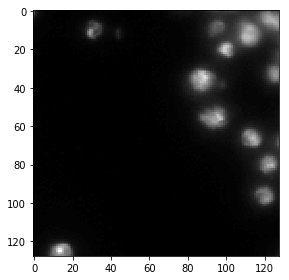

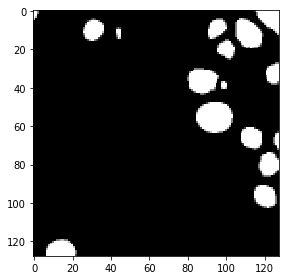

In [7]:
##Showing image and mask image 
from skimage.io import imread, imshow
imshow(x[0])
plt.show()
imshow(np.squeeze(y[0]))
plt.show()

In [8]:
##Split the computing power to 1/3
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
NAME = "Multiple-Tensorboard-{}".format(int(time.time()))

In [10]:
tensorboard = TensorBoard(log_dir='/Users/SinVinVin/Desktop/data-science-bowl-2018/logs/{}'.format(NAME))

In [11]:
# from keras import backend as K
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)
#######metrics = [mean_iou] ####### if used ####### 

Using TensorFlow backend.


In [11]:
#####Unet#####
def UNet():
    f = [16, 32, 64, 128, 256] # dimension array for down_sample and up_sample
    inputs = keras.layers.Input((128, 128, 3)) #input format

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 -> 64
    c2, p2 = down_block(p1, f[1])  # 64 -> 32
    c3, p3 = down_block(p2, f[2])  # 32 -> 16
    c4, p4 = down_block(p3, f[3])  # 16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8 -> 16
    u2 = up_block(u1, c3, f[2])  # 16 -> 32
    u3 = up_block(u2, c2, f[1])  # 32 -> 64
    u4 = up_block(u3, c1, f[0])  # 64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

## Down_block contains 2 2D convo layer 
## Arguments: filters is the number of output filters,
## kernel size is to specify height & width of the convo window
## padding= same aka half padding means output = input size when strides equal to 1
## if strides is not equal to 1, then padding = same means apply padding according to
## the ratio of strides in reverse
## relu is a nonlinear activation and it is quick and easy since its just between 1&0
## MaxPool2d is a maxpooling function and it selects the max value within a grid
## to down sample the image pixels.
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p
## up_blocking is similar to down_blocking but in reverse 
## however it has an extra step of concatenating from both the 
## process of up_sampling and the process of down sampling across from 
## the other side of unet
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c
## Bottleneck does not downsample-maxpool nor upsample-concatenate
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [12]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
_____________________________________

In [13]:
from tensorflow.python.keras.callbacks import TensorBoard

In [15]:
####Still need TensorBoard implementation to visualize the model metrics
results = model.fit(x, y, validation_split=0.1, batch_size=32, epochs=20, callbacks=[tensorboard])
####stop when val_loss increases and training_loss gets too small

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 69s 114ms/sample - loss: 15.5766 - acc: 0.8457 - val_loss: 10.5584 - val_acc: 0.8602
Epoch 2/20
603/603 [==============================] - 67s 111ms/sample - loss: 9.9096 - acc: 0.8457 - val_loss: 6.9206 - val_acc: 0.8620
Epoch 3/20
603/603 [==============================] - 67s 112ms/sample - loss: 7.2924 - acc: 0.8565 - val_loss: 5.3990 - val_acc: 0.8874
Epoch 4/20
603/603 [==============================] - 67s 112ms/sample - loss: 6.1788 - acc: 0.8942 - val_loss: 4.3243 - val_acc: 0.9245
Epoch 5/20
603/603 [==============================] - 69s 115ms/sample - loss: 4.5347 - acc: 0.9261 - val_loss: 3.4959 - val_acc: 0.9362
Epoch 6/20
603/603 [==============================] - 67s 111ms/sample - loss: 3.9681 - acc: 0.9352 - val_loss: 3.0841 - val_acc: 0.9471
Epoch 7/20
603/603 [==============================] - 67s 111ms/sample - loss: 3.5002 - acc: 0.9412 - val_loss: 2.9488 - val_acc: 0

In [16]:
model.save("/Users/SinVinVin/Desktop/data-science-bowl-2018/HS630Final_20epoch.h5")

In [17]:
test_path = '/Users/SinVinVin/Desktop/data-science-bowl-2018/stage1_test/'
test_ids = next(os.walk(test_path))[1]
print(len(test_ids))

65


In [18]:
#### reading in test data which is similar to train data
def test_readin(test_id_name):
    ## due to the structure of the directory, image path and mask path are separated
    ## "id_name" - string of the files names and joining to be the new path for image
    test_image_path = os.path.join(test_path, test_id_name, "images", test_id_name) + ".png"
    ## Reading Image
    ## Using openCV to read an image, so there will be a loop below
    test_image = cv2.imread(test_image_path, 1)[:,:,:3]
    ## resize the image to 128X128
    test_image = cv2.resize(test_image, (image_size, image_size))
    test_image_upper = np.amax(test_image)
    test_image_lower = np.amin(test_image)
    test_image = ((test_image-test_image_lower)/(test_image_upper-test_image_lower))*255
    test_image = test_image/255.0
    return test_image
def test_loop_in(index):
    test_files = test_ids[0:65]
    test_image = []
    
    for test_id_name in test_files:
        test_img_loop = test_readin(test_id_name)
        test_image.append(test_img_loop)

    test_image = np.array(test_image)

    return test_image

In [19]:
z = test_loop_in(0)

In [20]:
test_result = model.predict(z)

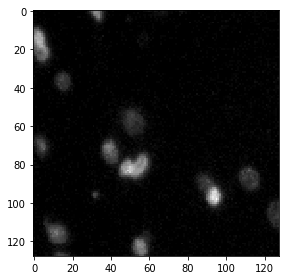

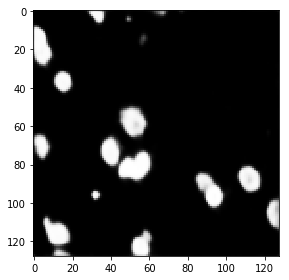

In [21]:
imshow((z[15]))
plt.show()
imshow(np.squeeze(test_result[15]))
plt.show()

In [22]:
model.evaluate(x, y)

670/670 [==============================] - 27s 41ms/sample - loss: 2.4644 - acc: 0.9539


[2.4644380341714887, 0.9539088]

In [23]:
#####iou
target = z
prediction = test_result
intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)
iou_score = np.sum(intersection) / np.sum(union)


In [24]:
print(iou_score)

0.9749946789863783


In [ ]:
## $ tensorboard --logdir=logs/<<folder-name>>

In [30]:
test_path_stage2 = '/Users/SinVinVin/Desktop/data-science-bowl-2018/stage2_test_final/'
test_ids_stage2 = next(os.walk(test_path_stage2))[1]
print(len(test_ids_stage2))
#input of the stage 2 test data

def test_readin_stage2(test_id_name_stage2):
    ## due to the structure of the directory, image path and mask path are separated
    ## "id_name" - string of the files names and joining to be the new path for image
    test_image_path_stage2 = os.path.join(test_path_stage2, test_id_name_stage2, "images", test_id_name_stage2) + ".png"
    ## Reading Image
    ## Using openCV to read an image, so there will be a loop below
    test_image_stage2 = cv2.imread(test_image_path_stage2, 1)[:,:,:3]
    ## resize the image to 128X128
    test_image_stage2 = cv2.resize(test_image_stage2, (image_size, image_size))
    test_image_upper_stage2 = np.amax(test_image_stage2)
    test_image_lower_stage2 = np.amin(test_image_stage2)
    test_image_stage2 = ((test_image_stage2-test_image_lower_stage2)/(test_image_upper_stage2-test_image_lower_stage2))*255
    test_image_stage2 = test_image_stage2/255.0
    return test_image_stage2
def test_loop_in_stage2(index):
    test_files_stage2 = test_ids_stage2[0:3019]
    test_image_stage2 = []
    
    for test_id_name_stage2 in test_files_stage2:
        test_img_loop_stage2 = test_readin_stage2(test_id_name_stage2)
        test_image_stage2.append(test_img_loop_stage2)

    test_image_stage2 = np.array(test_image_stage2)

    return test_image_stage2

3019


In [31]:
z_stage2 = test_loop_in_stage2(0)

In [32]:
test_result_stage2 = model.predict(z_stage2)

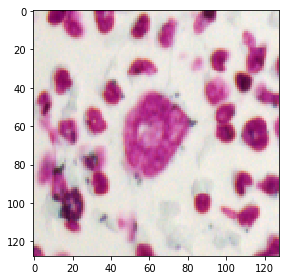

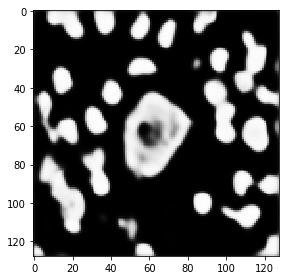

In [35]:
imshow((z_stage2[20]))
plt.show()
imshow(np.squeeze(test_result_stage2[20]))
plt.show()

In [38]:
#####iou
target = z_stage2
prediction = test_result_stage2
intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)
iou_score_stage2 = np.sum(intersection) / np.sum(union)

In [39]:
print(iou_score_stage2)

0.8609084393387914


In [ ]:
#When testing the stage2 test data, the model does not perform as well as the first testing set based on the iou scores.
#The epoch has changed to 20 from 60 after analyzing the tensorboard. when looking at the 
#epoch vs validation loss graph. model perform the best at 19 epoch which is when validation loss starts to increase while
#the accury increases which is a classic example of overfitting. Therefore I have changed the epoch to 20